# Подготовка и импорт библиотек

In [60]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import plotly.graph_objects as go
import requests
from bs4 import BeautifulSoup
import urllib.request
import warnings
warnings.filterwarnings('ignore')
import time

#библиотеки для сглаживания сезонности в данных и отслеживания треднов
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa import filters
from statsmodels.tsa import seasonal
from statsmodels.tsa.filters import hp_filter
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.ticker import StrMethodFormatter


### Технические моменты

1) Сразу скажу, что для многих графиков в проекте данные были взяты из excel-таблиц ЦБ или Росстата, на сайтах они присутствуют только в таком виде. Я обычно предварительно вытягивал нужные показатели в отдельный csv-файл, чтобы сократить количество ненужного кода для выделения отдельных строчек из нагруженных многостраничных статистических сводок. Оригиналы всех файлов могут быть найдены в папке data_raw, уже подготовленные csv - в репозитории)

2) Микрокредитные и микрофинансовые компании/организации/ (МКК и МФК / МФО и МКО) -- юридически разные термины. У них разный размер собственных средств, требования по аудиту и органичения на выдаваемые суммы, но нас эта разница в рамках проекта волнует не так сильно. Так как мы в основном будем рассматривать взаимодействие именно физических лиц с данными организациями, а для физлиц в обоих типах принцип одинаковый -- быстрый займ без долгого процесса оформления, сверки документов и оценки рисков в обмен на крайне высокий процент. В проекте, если разница не важна, для лаконичности я буду называть оба типа органиций микрофинансовыми (МФО). Если разница в конкретном разделе важна -- буду специфицирвоать.

# Закредитованность населения России



По данным РБК, к 1 января 2024 года число россиян, имеющих кредиты, достигло 50 миллионов. При этом чуть менее 8 миллионов имеют микрокредит или займ в МФО (микрофинансовая организация). Как можно предположить, исходя из общего социоэкономичесткого контекста, рост закредитованности населения в стране говорит скорее не об активной фазе роста экономики, а о том, что доходы людей перестают соответствовать их стандартам потребления. Займы в МФО являются достаточно рискованными, т.к. годовые проценты по ним могут достигать трехзначных значений, поэтому рост спроса на микрокредиты в последние несколько лет является крайне тревожным маркером.

 В этом исследовании мы постараемся посмотреть на проблему закредитованности россиян, уделив отдельное внимание микрофинансовым (микрокредитным) организациям и их взаимодействию с заемщиками-физическими лицами в РФ. Также по ходу исследования я выскажу несколько гипотез, которые мы постараемся проверить на данных.


## Общая статистика


Сначала посмотрим на общие показатели, касающиеся деятельности МФО в России.


(data_raw/Обзор ключевых показателей микрофинансовых институтов

источник: ЦБ ФР https://www.cbr.ru/analytics/microfinance/)

In [2]:
microloan_maindata = pd.read_csv("обзор_ключевых_показателей_микрофинансовых_институтов.csv")

#готовим данные к отрисовке графиков
microloan_maindata['date'] = pd.to_datetime(microloan_maindata['date'])
microloan_maindata.set_index('date', inplace=True)


for column in microloan_maindata.columns:
  if column != 'date':
    #боремся с запятыми в качестве разделителей
    microloan_maindata[column]=microloan_maindata[column].str.replace(',','')
    microloan_maindata[column] = pd.to_numeric(microloan_maindata[column])

    if column == 'mloan_total_number' or column == 'mloan_private_number':
      #данные по этим показателям с явно выраженной сезонностью, поэтому нужно будет применить к ним сглаживание, чтобы лучше отследить общий тренд
      seasonal_decomposition = sm.tsa.seasonal_decompose(microloan_maindata[column], model='additive', period=4)
      microloan_maindata[f'{column}_seas'] = seasonal_decomposition.trend

microloan_maindata.head(5)

,mloan_total_number,mloan_private_number,loan_body_total,loan_body_private,interest_private,mloan_total_number_seas,mloan_private_number_seas
date,,,,,,,
2018-09-30,21245181.0,21222863.0,148585.89,120951.99,57625.69,NaN,NaN
2018-12-31,28902466.0,28870483.0,163636.97,134033.54,64960.44,NaN,NaN
2019-03-31,8355092.0,8347810.0,173605.78,143030.12,71524.30,1.930706e+07,1.928707e+07
2019-06-30,16878670.0,16861566.0,189849.61,155622.73,81901.61,2.038302e+07,2.036224e+07
2019-09-30,24938852.0,24913940.0,201338.02,164969.63,87867.88,2.098191e+07,2.096084e+07


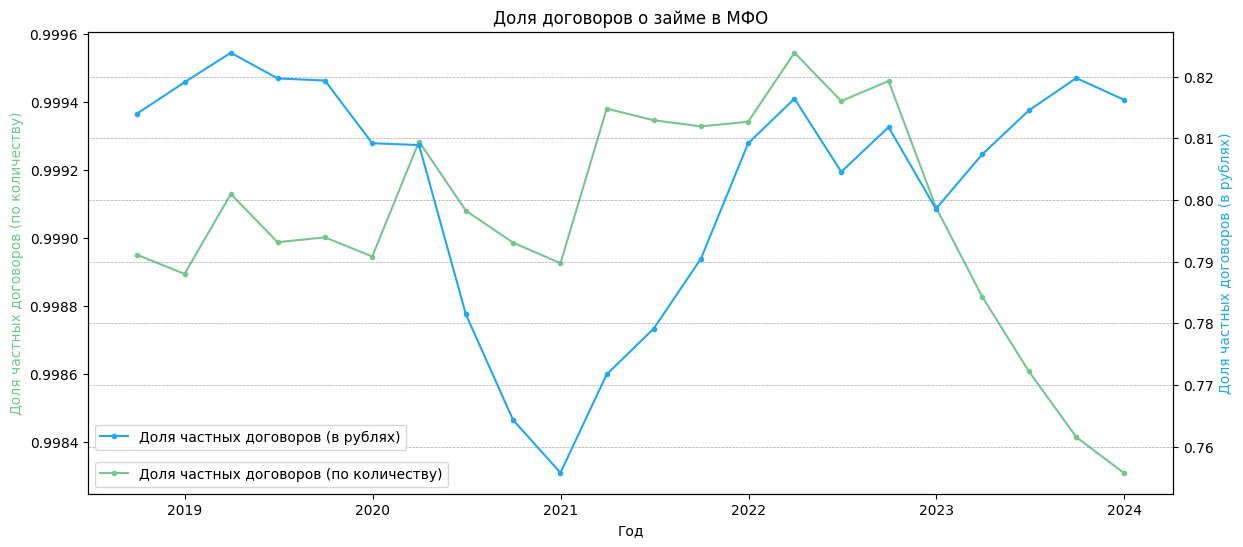

In [3]:
#Посчитаем нужные доли и отрисуем графики
microloan_maindata['private_share_number']=microloan_maindata['mloan_private_number']/microloan_maindata['mloan_total_number']
microloan_maindata['private_share_body']=microloan_maindata['loan_body_private']/microloan_maindata['loan_body_total']


fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.plot(microloan_maindata['private_share_number'], label='Доля частных договоров (по количеству)', color ='#76c68f',marker='o', markersize=3)
ax1.set_xlabel('Год')
ax1.set_ylabel('Доля частных договоров (по количеству)', color='#76c68f')

ax2 = ax1.twinx()
ax2.plot(microloan_maindata['private_share_body'], label='Доля частных договоров (в рублях)', color ='#22a7f0',marker='o', markersize=3)
ax2.set_ylabel('Доля частных договоров (в рублях)', color='#22a7f0')

plt.title('Доля договоров о займе в МФО')
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
ax1.legend(loc='lower left')
ax2.legend(loc='lower left', bbox_to_anchor=(0, 0.08))
plt.show()


Как мы видим, с 2019 по начало 2024 года, большую часть клиентов МФО составляют именно физические лица. Они заключают более 99% всех договоров о займах. На них мы и сконцентрируемся

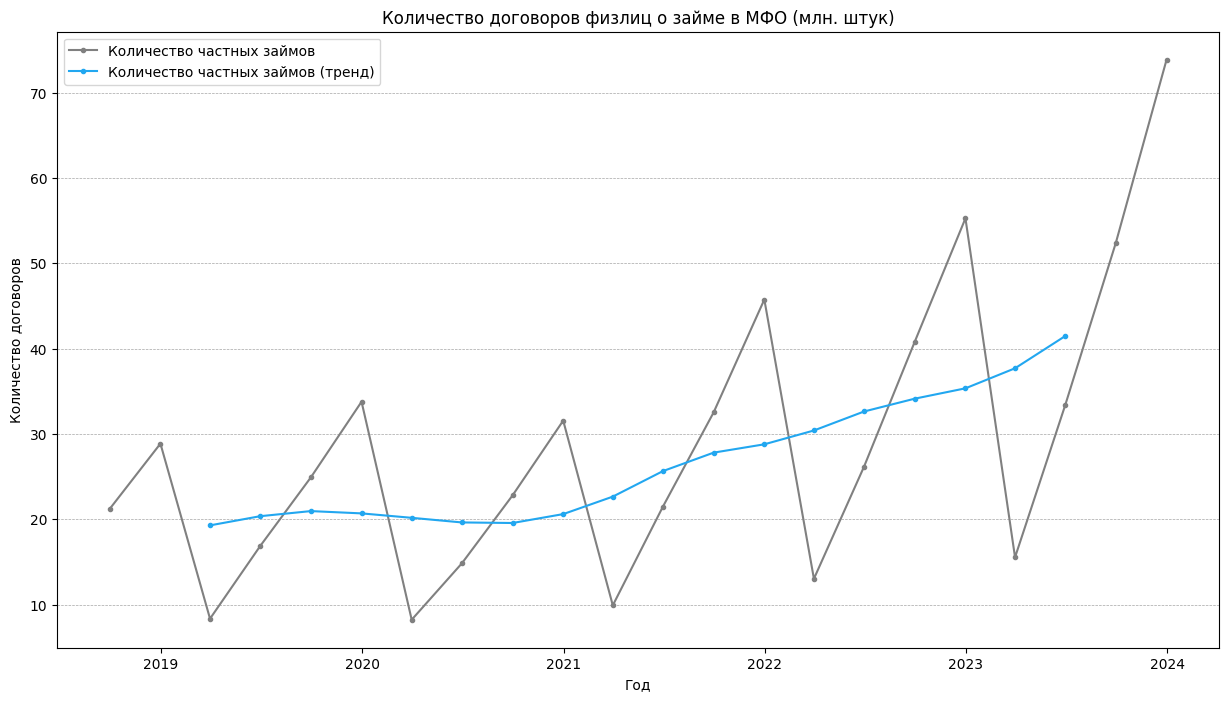

In [4]:
#отрисовываем графики по количеству частных договоров
plt.figure(figsize=(15, 8))
plt.plot(microloan_maindata['mloan_private_number'] / 1e6, label='Количество частных займов', color ='grey',marker='o', markersize=3)  #такие штуки с делением числовых данных на что-то здесь и далее вызваны тем, что matplotlib сам выбирает масштаб по оси y, иногда не очень удачно
plt.plot(microloan_maindata['mloan_private_number_seas'] / 1e6, label='Количество частных займов (тренд)', color ='#22a7f0',marker='o', markersize=3)

plt.xlabel('Год')
plt.ylabel('Количество договоров')
plt.title('Количество договоров физлиц о займе в МФО (млн. штук)')
plt.legend()

plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.show()

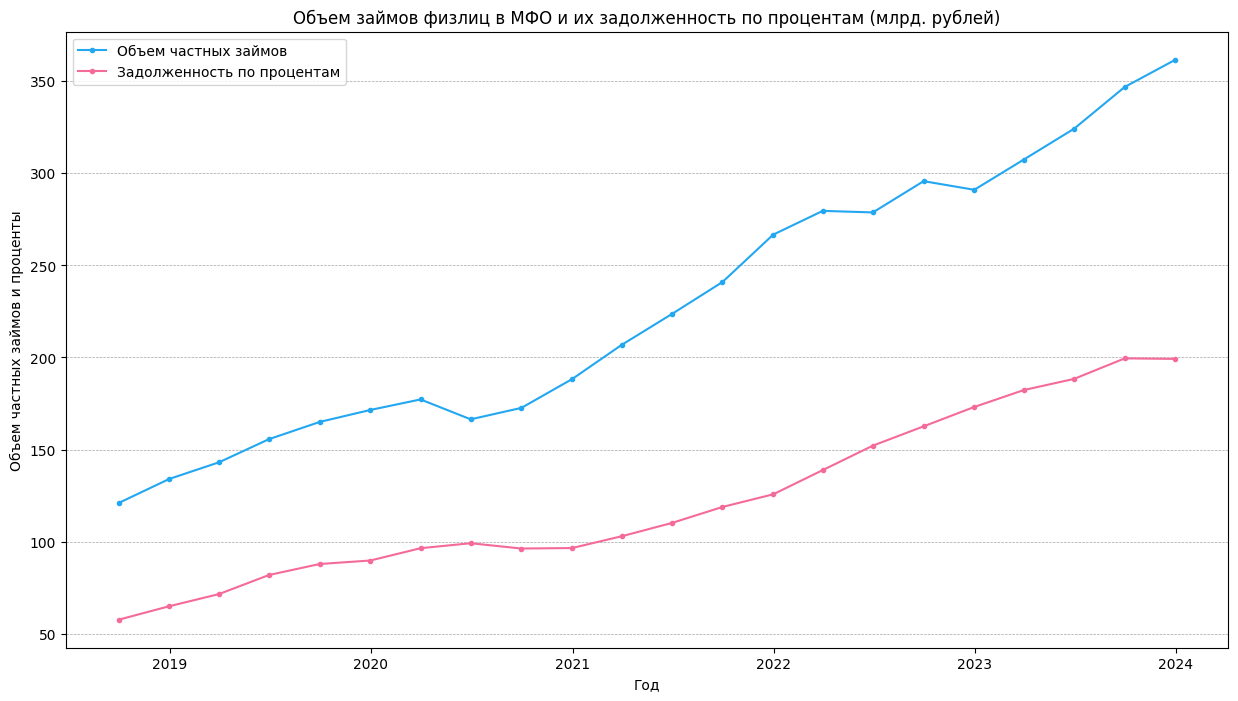

In [5]:
#отрисовываем графики по объему частных займов и по процентам
plt.figure(figsize=(15, 8))
plt.plot(microloan_maindata['loan_body_private'] / 1000, label='Объем частных займов', color ='#22a7f0',marker='o', markersize=3)
plt.plot(microloan_maindata['interest_private'] / 1000, label='Задолженность по процентам', color ='#f46a9b',marker='o', markersize=3)

plt.xlabel('Год')
plt.ylabel('Объем частных займов и проценты')
plt.title('Объем займов физлиц в МФО и их задолженность по процентам (млрд. рублей)')
plt.legend()

plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.show()

Общая статистика по РФ показывает удручающие результаты. Это и общий объем микрозаймов более чем на 350 миллиардов рублей, и явно восходящий тренд по количеству заключенных договоров о займе. Быстрые кредиты под огромный процент становятся нормой для все большего количества россиян.

## Региональный разрез

Соберем данные о закредитованности россиян в региональном разрезе. Идея в том, чтобы посмотреть на регионы, которые испытывают наибольшие проблемы с закредитованностью (здесь уже посмотрим не только на займы в МФО, но и на обычные кредиты). Для этого нам нужно будет сопоставить географические данные, население регионов и, собственно, долговую нагрузку.



Для отрисовки карт я загрузил датасет с границами регионов РФ (возможно, такой лежит где-то еще в открытом доступе, но я нашел только у какого-то добряка на гитхабе, так что как есть)


(Источник карты с регионами -- https://github.com/timurkanaz/Russia_geojson_OSM/tree/master)

In [6]:
russia_regions_df = gpd.read_file("Russia_regions.geojson")
russia_regions_df.info()

#переводим в другую географическую проекцию, чтобы в итоге отображалось красивее
russia_regions_df_prj = russia_regions_df.to_crs('ESRI:102027')

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   region    85 non-null     object  
 1   geometry  85 non-null     geometry
dtypes: geometry(1), object(1)
memory usage: 1.5+ KB


<Axes: >

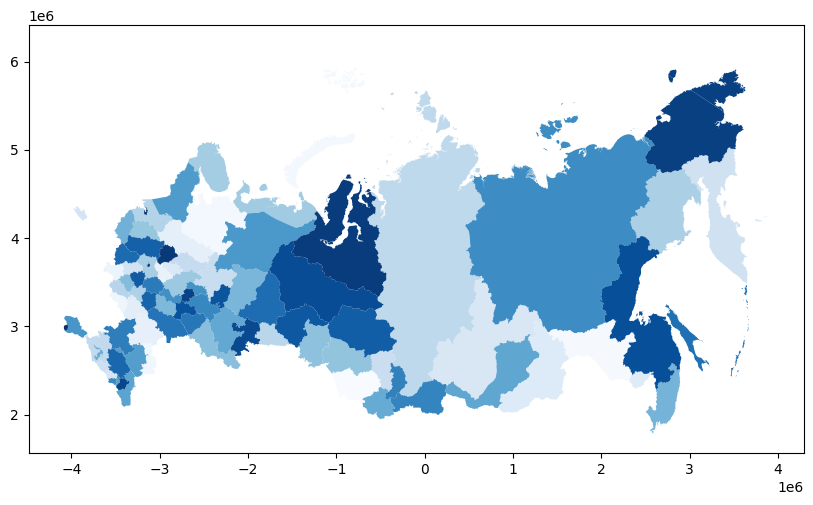

In [7]:
#убедимся, что необъятная не потеряла ничего в процессе скачивания и загрузки, цвета пока не имеют смысла
russia_regions_df_prj.plot(column='region', linewidth=0.5, cmap='Blues', figsize=[10, 10])

In [8]:
russia_regions_df_prj

,region,geometry
0,Алтайский край,"POLYGON ((-783763.259 2172259.786, -784667.756..."
1,Амурская обл.,"POLYGON ((2347391.642 2448854.841, 2341079.127..."
2,Архангельская обл.,"MULTIPOLYGON (((-2617273.047 4405928.320, -261..."
3,Астраханская обл.,"POLYGON ((-3196095.507 2462846.415, -3196601.4..."
4,Белгородская обл.,"POLYGON ((-3433691.179 3163218.492, -3433708.8..."
...,...,...
80,Ямало-Ненецкий АО,"MULTIPOLYGON (((-1189263.694 4270648.652, -118..."
81,Ярославская обл.,"POLYGON ((-3027941.399 3752561.523, -3027470.2..."
82,г. Москва,"MULTIPOLYGON (((-3152532.005 3695064.198, -315..."
83,г. Санкт-Петербург,"MULTIPOLYGON (((-3169352.828 4321097.578, -316..."


Следующий шаг — соединить геоданные с региональными данными задолженности по кредитам* и данными по численности населения**.


(*data_raw/Информация о кредитах, предоставленных физическим лицам - резидентам

источник: ЦБ ФР https://cbr.ru/statistics/bank_sector/sors/



**data_raw/Численность населения по полу и возрасту 2022


источник: Росстат https://rosstat.gov.ru/folder/12781)

In [9]:
loans_russia = pd.read_csv("население_и_закредитованность_по_регионам_prep.csv")

#географичекий дата фрейм отфильтрован лексикографически, так что сделаем с моим то же самое

loans_russia_sorted = loans_russia.sort_values(by='region')
loans_russia_sorted = loans_russia_sorted.reset_index(drop=True)
loans_russia_sorted.head(5)

,region,population_total,population_young,population_workforce,population_old,loans,loans_overdue
0,Алтайский край,2154932,424089,1182444,548399,416951,16429
1,Амурская область,763570,154011,448161,161398,218215,7061
2,Архангельская область,1016030,185226,564960,265844,268995,7397
3,Архангельская область без автономии,974604,175879,540421,258304,256515,7110
4,Астраханская область,957772,203640,543830,210302,203600,8335


Сразу видим какие-то левые пояснения типа "без автономии", которые придется почистить, если в географическом дф таких нет. Сделаем это через регулярные выражения

In [10]:
#регулярное выражение игнорирует слова "автономный" и "автономная", которые являются нормальными в нашем случае
#оно реагирует только на другие формы подстроки "автономн"
if not russia_regions_df_prj['region'].str.contains(r'автоном(?!н(ый|ая)\b)', case=False, regex=True).any():
  loans_russia_sorted = loans_russia_sorted[~loans_russia_sorted['region'].str.contains(r'автоном(?!н(ый|ая)\b)', case=False, regex=True)]

#следим за индексами, когда удаляем, а то потом все полетит
loans_russia_sorted = loans_russia_sorted.reset_index(drop=True)
loans_russia_sorted


<ipython-input-10-ce01bfe41afc>:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if not russia_regions_df_prj['region'].str.contains(r'автоном(?!н(ый|ая)\b)', case=False, regex=True).any():
<ipython-input-10-ce01bfe41afc>:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  loans_russia_sorted = loans_russia_sorted[~loans_russia_sorted['region'].str.contains(r'автоном(?!н(ый|ая)\b)', case=False, regex=True)]


,region,population_total,population_young,population_workforce,population_old,loans,loans_overdue
0,Алтайский край,2154932,424089,1182444,548399,416951,16429
1,Амурская область,763570,154011,448161,161398,218215,7061
2,Архангельская область,1016030,185226,564960,265844,268995,7397
3,Астраханская область,957772,203640,543830,210302,203600,8335
4,Белгородская область,1536466,258850,873576,404040,282773,10964
...,...,...,...,...,...,...,...
80,Ямало-Ненецкий автономный округ,511244,118576,329920,62748,254627,6095
81,Ярославская область,1205637,214396,668932,322309,219033,7765
82,г. Москва,13015126,2047759,7539518,3427849,4202962,120789
83,г. Санкт-Петербург,5607916,838937,3365469,1403510,1883381,42591


Ура, у нас 85 строк в географическом дф и 85 в собранном мной! Осталось только проверить, не удалил ли я чего-то лишнего. Чтобы игнорировать разные написания одних и тех же по смыслу слов ("обл" и "область", "АО" и "автономный округ"), будем смотреть только на на первые слова. Не забудем также и про "город федерального значения Севастополь" / "г. Севастополь". Если все ок, выведет только одно несоответствие как раз в последней строке (84).

In [11]:
# Получение первых слов из столбцов с названием региона
first_words_russia_regions = russia_regions_df_prj['region'].str.split().str[0]
first_words_loans_russia = loans_russia_sorted['region'].str.split().str[0]

# Сравнение первых слов и вывод несоответствующих строк
for idx, (word_russia, word_loans) in enumerate(zip(first_words_russia_regions, first_words_loans_russia)):
    if word_russia != word_loans:
        print(f'В дата фреймах есть несоответствия. Это регион {idx}')

В дата фреймах есть несоответствия. Это регион 84


Наконец, мы готовы добавить данные по кредитам и населению в географический датафрейм.

In [12]:
for column in loans_russia_sorted.columns:
  if column != 'region':
    russia_regions_df_prj[column] = loans_russia_sorted[column]

russia_regions_df_prj

,region,geometry,population_total,population_young,population_workforce,population_old,loans,loans_overdue
0,Алтайский край,"POLYGON ((-783763.259 2172259.786, -784667.756...",2154932,424089,1182444,548399,416951,16429
1,Амурская обл.,"POLYGON ((2347391.642 2448854.841, 2341079.127...",763570,154011,448161,161398,218215,7061
2,Архангельская обл.,"MULTIPOLYGON (((-2617273.047 4405928.320, -261...",1016030,185226,564960,265844,268995,7397
3,Астраханская обл.,"POLYGON ((-3196095.507 2462846.415, -3196601.4...",957772,203640,543830,210302,203600,8335
4,Белгородская обл.,"POLYGON ((-3433691.179 3163218.492, -3433708.8...",1536466,258850,873576,404040,282773,10964
...,...,...,...,...,...,...,...,...
80,Ямало-Ненецкий АО,"MULTIPOLYGON (((-1189263.694 4270648.652, -118...",511244,118576,329920,62748,254627,6095
81,Ярославская обл.,"POLYGON ((-3027941.399 3752561.523, -3027470.2...",1205637,214396,668932,322309,219033,7765
82,г. Москва,"MULTIPOLYGON (((-3152532.005 3695064.198, -315...",13015126,2047759,7539518,3427849,4202962,120789
83,г. Санкт-Петербург,"MULTIPOLYGON (((-3169352.828 4321097.578, -316...",5607916,838937,3365469,1403510,1883381,42591


Теперь, чтобы посмотреть на регионы, которые испытывают наибольшие проблемы с закредитованностью, можем рассчитать средний долг на одного человека в регионе (будем считать работоспособных - population_workforce или работоспособных + пенсионеров - population_old, так как они тоже в теории могут брать кредиты, хотя на практике это случается намного реже) и среднюю просроченную задолженность на человека - loans_overdue.

Также заметим, что в данных ЦБ кредиты даны в миллионах рублей.

Text(0.5, 1.0, 'Cредняя сумма долга на одного работоспособного жителя региона (тыс. руб)')

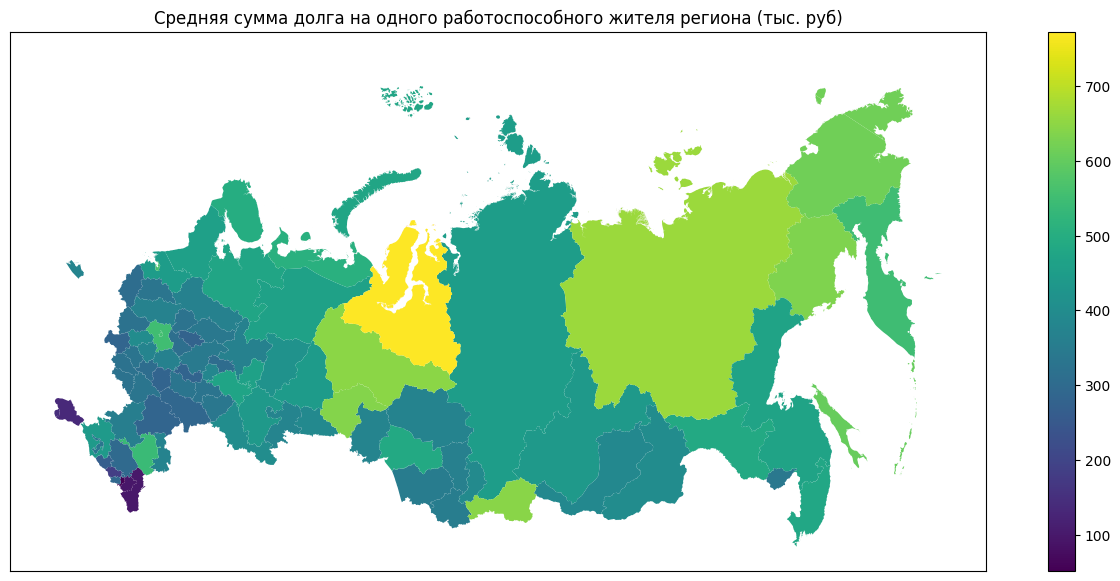

In [13]:
russia_regions_df_prj['debt_wf'] = (russia_regions_df_prj['loans'] * 1000) / russia_regions_df_prj['population_workforce']

#рисуем карту
russia_regions_df_prj.plot(column='debt_wf', linewidth=0.5, cmap='viridis', legend=True, figsize=[16, 7])
#убираем некрасивые метки
plt.xticks([])
plt.yticks([])
plt.title('Cредняя сумма долга на одного работоспособного жителя региона (тыс. руб)')


Text(0.5, 1.0, 'Cредняя сумма долга на одного дееспособного жителя региона (тыс. руб)')

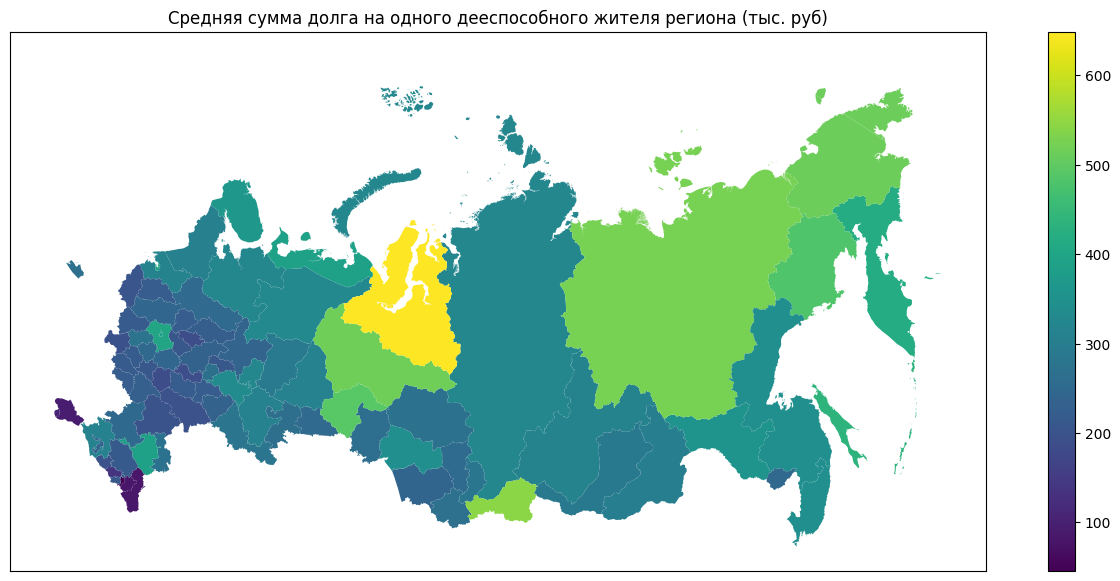

In [14]:
russia_regions_df_prj['debt_wf_old'] = (russia_regions_df_prj['loans'] * 1000) / (russia_regions_df_prj['population_workforce'] + russia_regions_df_prj['population_old'])

russia_regions_df_prj.plot(column='debt_wf_old', linewidth=0.5, cmap='viridis', legend=True, figsize=[16, 7])
plt.xticks([])
plt.yticks([])
plt.title('Cредняя сумма долга на одного дееспособного жителя региона (тыс. руб)')

Кажется, победители по части закредитованности уже вырисовываются, но давайте сделаем все честно -- выведем топ-5.

По долгу на работоспособного жителя:

In [15]:
highest_debt_wf_regions = russia_regions_df_prj.nlargest(5, 'debt_wf')
highest_debt_wf_regions[['region', 'debt_wf']]

,region,debt_wf
80,Ямало-Ненецкий АО,771.784069
54,Республика Саха (Якутия),662.643778
75,Ханты-Мансийский АО - Югра,646.854858
57,Республика Тыва,643.130995
71,Тюменская обл.,638.394524


По долгу на дееспособного жителя:

In [16]:
highest_debt_wf_old_regions = russia_regions_df_prj.nlargest(5, 'debt_wf_old')
highest_debt_wf_old_regions[['region', 'debt_wf_old']]

,region,debt_wf_old
80,Ямало-Ненецкий АО,648.453656
57,Республика Тыва,543.902450
54,Республика Саха (Якутия),524.768647
75,Ханты-Мансийский АО - Югра,514.915142
79,Чукотский АО,512.919378


Наименее проблемными оказываются регионы

In [17]:
lowest_debt_wf_regions = russia_regions_df_prj.nsmallest(5, 'debt_wf')
lowest_debt_wf_regions[['region', 'debt_wf']]

,region,debt_wf
47,Республика Ингушетия,51.936381
77,Чеченская Республика,95.798256
46,Республика Дагестан,98.353759
51,Республика Крым,134.344016
84,город федерального значения Севастополь,146.525230


Однако, данные не столь однозначны. Если посчитать, например, долю просроченного долга, то самые проблемные регионы, парадоксально, показывают себя вполне неплохо. Возможно, несмотря на относительно высокую долговую нагрузку, люди в целом справляются с погашением.

Text(0.5, 1.0, 'Доля просроченного долга в регионе')

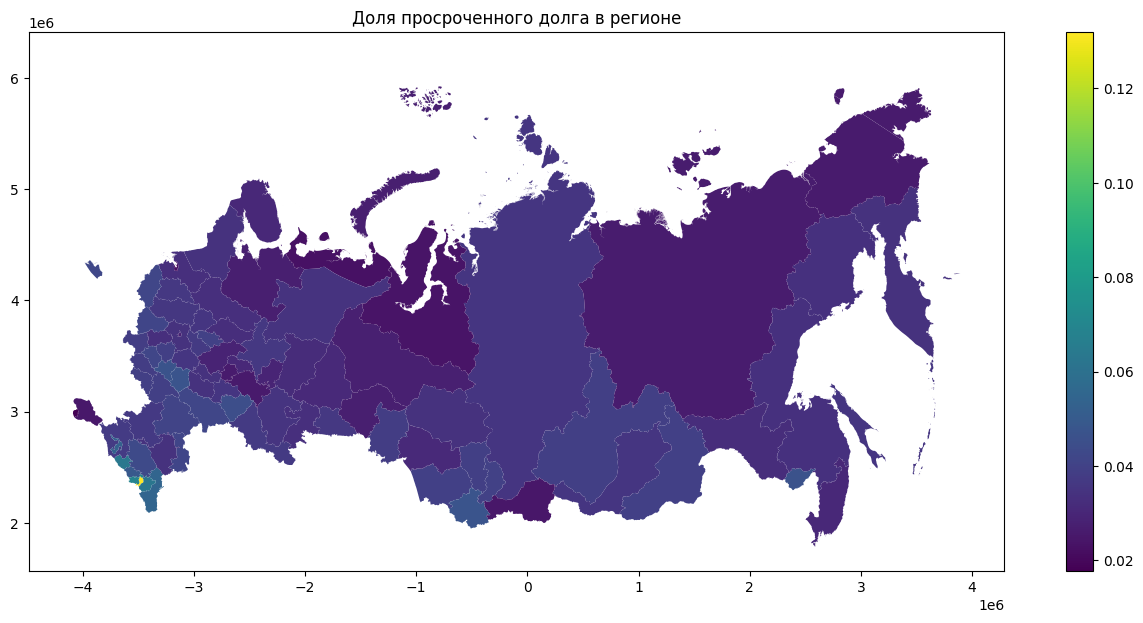

In [18]:
russia_regions_df_prj['overdue_debt_ratio'] = (russia_regions_df_prj['loans_overdue']) / russia_regions_df_prj['loans']

#рисуем карту
russia_regions_df_prj.plot(column='overdue_debt_ratio', linewidth=0.5, cmap='viridis', legend=True, figsize=[16, 7])
plt.title('Доля просроченного долга в регионе')

In [19]:
lowest_overdue_debt_ratio = russia_regions_df_prj.nsmallest(5, 'overdue_debt_ratio')
lowest_overdue_debt_ratio[['region', 'overdue_debt_ratio']]

,region,overdue_debt_ratio
84,город федерального значения Севастополь,0.017721
83,г. Санкт-Петербург,0.022614
31,Ненецкий АО,0.022997
80,Ямало-Ненецкий АО,0.023937
57,Республика Тыва,0.024728


## Вернемся к вопросу МФО

Существует представление о том, что типичный заемщик в МФО — это человек из провинции или житель небольшого города. Можем попробовать проверить, есть ли основания для такой гипотезе о портрете заемщика.

Идея в том, чтобы сравнить количество отделений МФО, скажем, на сто тысяч человек в городах-миллионниках с аналогичным значением в менее населенных городах. Логично, что больше отделений будет именно там, где у МФО может быть больше потенциальных клиентов.


Сначала соберем пул городов России с населением. В качестве "менее населенных" логично не брать совсем маленькие городки с населением в несколько тысяч, потому что:


1) там обычно мало бизнес-организаций в принципе, не только МФО.


2) сбор данных об МФО может быть затруднен тем, что точки могут вообще не присутствовать на картах или информация может быть неактуальной.

Начнем с населения. Есть, конечно, данные Росстата в эксель-таблицах, но мы тут дата сайнсом занимаемся, а не бухучетом. Поэтому получим данные с Википедии с помощью веб-скреппинга.


In [38]:
response = urllib.request.urlopen('https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D0%BE%D0%B2_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8_%D1%81_%D0%BD%D0%B0%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5%D0%BC_%D0%B1%D0%BE%D0%BB%D0%B5%D0%B5_100_%D1%82%D1%8B%D1%81%D1%8F%D1%87_%D0%B6%D0%B8%D1%82%D0%B5%D0%BB%D0%B5%D0%B9')
html = response.read()
html = html.decode('utf-8')

In [39]:
soup = BeautifulSoup(html, 'html.parser')

Получили html, теперь будем парсить и сохранять данные в отдельный дата фрейм. Благо на сайте список дан удобной табличкой, которую будет проще найти и привести к адекватному виду.

In [40]:
cities_population_df = pd.DataFrame(columns = ['city', 'population'])

In [41]:
#нашли класс таблички через код страницы и вытянули ее
cities_wiki_table = soup.find('table', {'class': 'wikitable sortable collapsible'})

rows = cities_wiki_table.find_all('tr')

# Напечатаем первые несколько строк, чтобы было понятнее, в каком виде таблица
for row in rows[:5]:
    print(row)

<tr align="center">
<th colspan="2">№</th>
<th colspan="1" rowspan="2">Город</th>
<th colspan="14">Население, тыс. человек
</th></tr>
<tr align="center">
<th data-sort-type="number"></th>
<th data-sort-type="number"><span style="font-size:85%;">в<br/>1897<br/><sup class="reference" id="cite_ref-16"><a href="#cite_note-16">[d]</a></sup></span></th>
<th data-sort-type="number"><span style="font-size:85%;">1897</span></th>
<th data-sort-type="number"><span style="font-size:85%;">1926</span></th>
<th data-sort-type="number"><span style="font-size:85%;">1939</span></th>
<th data-sort-type="number"><span style="font-size:85%;">1959</span></th>
<th data-sort-type="number"><span style="font-size:85%;">1970</span></th>
<th data-sort-type="number"><span style="font-size:85%;">1979</span></th>
<th data-sort-type="number"><span style="font-size:85%;">1989</span></th>
<th data-sort-type="number"><span style="font-size:85%;">2002</span></th>
<th data-sort-type="number"><span style="font-size:85%;">2

In [42]:
cities_list = []
population_list = []

#проходимся по строчкам и вытягиваем оттуда:

for i in range(len(rows)):
  name_html = rows[i].find_all('a')

  #1) название города (также проверяем наличие символов квадратных скобок "[...]", которые на сайте тоже являются ссылкой на какую-то доп. информацию рядом с названием, но нас не интересуют)
  for name in name_html:
    if ("[" or "]") not in name.get_text():
        cities_list.append(name.get_text())

  #2) население. Нам нужно самое свежее число за 2024 год, поэтому берем 16-ю колонку таблицы
  population_html = rows[i].find_all('td')
  k = 0
  for population in population_html:
        k =k+1
        if k == 16:
          population_list.append(int(population.get_text()))

for i in range(len(population_list)):
  cities_population_df.loc[i] = [cities_list[i], population_list[i]]

Итак, у нас есть дата фрейм со 170 городами России (населением до 100 тысяч по убыванию) и собственно их население (в тысячах).

In [43]:
cities_population_df

,city,population
0,Москва,13150
1,Санкт-Петербург,5598
2,Новосибирск,1634
3,Екатеринбург,1536
4,Казань,1319
...,...,...
165,Элиста,103
166,Ноябрьск,103
167,Бердск,103
168,Ногинск,102


Тут должен быть крутой код со сбором информации о количестве отделений МФО в разных городах через парсинг Яндекс карт, но, к сожалению, ваш покорный слуга немного переоценил свои силы в этом вопросе. Количество отделений все равно сейчас появится ради продолжения нашего увлекательного путешествия по миру серого кредитования. Вы можете проверить числа сами, набрав "микрофинансовая организация" в строке поиска яндекс карт по определенному городу. Это был путь самурая.

In [44]:
cities_mfo_number = pd.read_csv("количество_мфо_по_городам.csv")
#соединим данные
cities_population_df['mfo_number'] = cities_mfo_number['mfo_number']
cities_population_df['alignment'] = cities_mfo_number['alignment']

cities_population_df

,city,population,mfo_number,alignment
0,Москва,13150,353.0,NaN
1,Санкт-Петербург,5598,154.0,NaN
2,Новосибирск,1634,168.0,NaN
3,Екатеринбург,1536,116.0,NaN
4,Казань,1319,89.0,NaN
...,...,...,...,...
165,Элиста,103,22.0,NaN
166,Ноябрьск,103,7.0,NaN
167,Бердск,103,16.0,NaN
168,Ногинск,102,7.0,NaN


У нас есть датафрейм с населением городов (в тысячах), количестве точек МФО в городе и столбец "alignment", который показывает принадлежность к Московской области (об этом позже).


Посмотрим, все ли хорошо с нашим дата фреймом и соберем какую-то статистику, разбив города на группы по населению

In [45]:
cities_population_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 170 entries, 0 to 169
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        170 non-null    object 
 1   population  170 non-null    int64  
 2   mfo_number  169 non-null    float64
 3   alignment   15 non-null     object 
dtypes: float64(1), int64(1), object(2)
memory usage: 6.6+ KB


In [52]:
#видим один NA в mfo_number
na_mfo_cities = cities_population_df[cities_population_df['mfo_number'].isna()]
na_mfo_cities

#мурино это де-факто уже СПБ, поэтому можно со спокойной душой его исключить
cities_population_df = cities_population_df.dropna(subset=['mfo_number'])


In [53]:
#также заполним ячейки alignment городов, не пренадлежащийх к Московской Области (т.е. пустые)
cities_population_df['alignment'] = cities_population_df['alignment'].fillna('не_МО')


#посчитаем количество МФО на сто тысяч человек

cities_population_df['mfo_per_capita'] = cities_population_df['mfo_number'] / (cities_population_df['population'] / 100)
cities_population_df

,city,population,mfo_number,alignment,mfo_per_capita,category
0,Москва,13150,353.0,не_МО,2.684411,Больше миллиона
1,Санкт-Петербург,5598,154.0,не_МО,2.750982,Больше миллиона
2,Новосибирск,1634,168.0,не_МО,10.281518,Больше миллиона
3,Екатеринбург,1536,116.0,не_МО,7.552083,Больше миллиона
4,Казань,1319,89.0,не_МО,6.747536,Больше миллиона
...,...,...,...,...,...,...
165,Элиста,103,22.0,не_МО,21.359223,От 100 до 150 тыс.
166,Ноябрьск,103,7.0,не_МО,6.796117,От 100 до 150 тыс.
167,Бердск,103,16.0,не_МО,15.533981,От 100 до 150 тыс.
168,Ногинск,102,7.0,не_МО,6.862745,От 100 до 150 тыс.


Построим сначала более простые графики

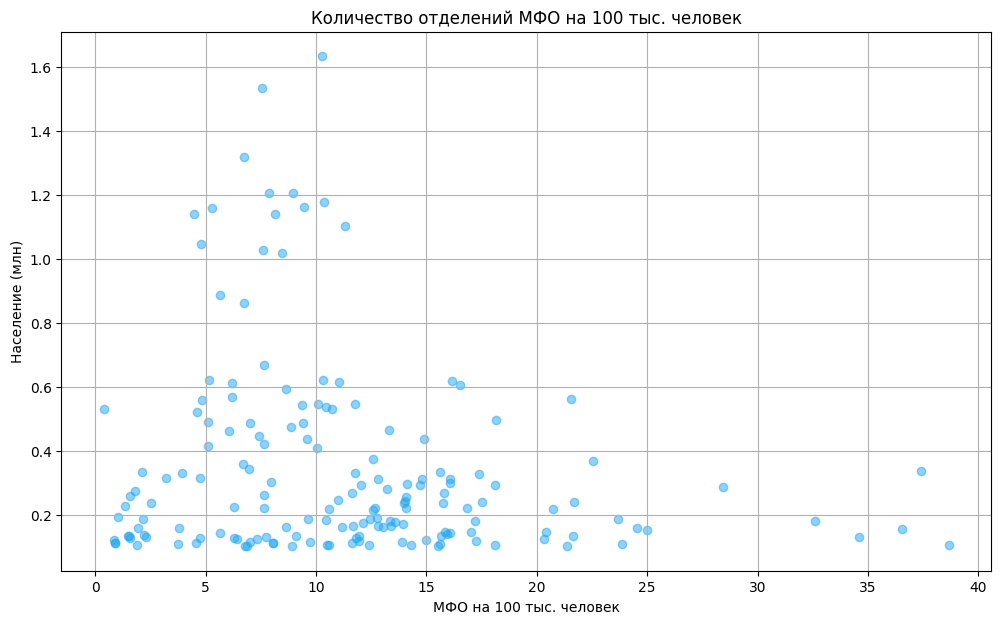

In [54]:
#для наглядности scatter plot-а временно уберем Москву и Санкт-Петербург

cities_population_df_scat = cities_population_df[~cities_population_df['city'].isin(['Москва', 'Санкт-Петербург'])]

plt.figure(figsize=(12, 7))
plt.scatter(cities_population_df_scat['mfo_per_capita'], cities_population_df_scat['population']/1000, c='#22a7f0', alpha=0.5)

plt.title('Количество отделений МФО на 100 тыс. человек')
plt.xlabel('МФО на 100 тыс. человек')
plt.ylabel('Население (млн)')
plt.grid(True)
plt.show()

Попробуем разбить города на группы по населенности и посмотреть на средний показатель МФО на сто тысяч человек по группам.

In [55]:
def population_split_cities(population):
    if population > 1000:
        return 'Больше миллиона'
    elif 500 < population <= 1000:
        return 'От 500 тыс. до миллиона'
    elif 250 < population <= 500:
        return 'От 250 до 500 тыс.'
    elif 150 < population <= 250:
        return 'От 150 до 250 тыс.'
    else:
        return 'От 100 до 150 тыс.'

cities_population_df['category'] = cities_population_df['population'].apply(population_split_cities)

mean_mfo_per_category = cities_population_df.groupby('category')['mfo_per_capita'].mean()
mean_mfo_per_category

category
Больше миллиона             7.295154
От 100 до 150 тыс.         11.302470
От 150 до 250 тыс.         13.414743
От 250 до 500 тыс.         11.626801
От 500 тыс. до миллиона     9.197022
Name: mfo_per_capita, dtype: float64

Тут возникает один момент, который я ранее обещал раскрыть. Если посмотреть на среднее по городам со значением alignment	= 'МО', то получается:

In [56]:
mean_mfo_mowcowregion = cities_population_df.groupby('alignment')[['mfo_per_capita', 'population']].mean()
mean_mfo_mowcowregion

,mfo_per_capita,population
alignment,,
МО,1.973726,193.2
не_МО,12.158431,478.0


Получается, что в городах, которые юридически отделены от Москвы, но де-факто практически в нее входят (некоторые из них граничат с МКАД), количество МФО крайне маленькое для их населения. Чтобы уменьшить выбросы в данных, возможно, стоит рассматривать дата фрейм без них.

In [57]:
cities_population_df_nomo = cities_population_df[~cities_population_df['alignment'].isin(['МО'])]
cities_population_df_nomo

,city,population,mfo_number,alignment,mfo_per_capita,category
0,Москва,13150,353.0,не_МО,2.684411,Больше миллиона
1,Санкт-Петербург,5598,154.0,не_МО,2.750982,Больше миллиона
2,Новосибирск,1634,168.0,не_МО,10.281518,Больше миллиона
3,Екатеринбург,1536,116.0,не_МО,7.552083,Больше миллиона
4,Казань,1319,89.0,не_МО,6.747536,Больше миллиона
...,...,...,...,...,...,...
165,Элиста,103,22.0,не_МО,21.359223,От 100 до 150 тыс.
166,Ноябрьск,103,7.0,не_МО,6.796117,От 100 до 150 тыс.
167,Бердск,103,16.0,не_МО,15.533981,От 100 до 150 тыс.
168,Ногинск,102,7.0,не_МО,6.862745,От 100 до 150 тыс.


Построим красивый график распределения по группам городов (не знаю, работает ли это в стримлите, но в гугл коллабе он еще и интерактивный. Выводится название города и точное значение МФО на тысячу человек при наведении на точку)

In [58]:
fig = px.scatter(cities_population_df_nomo, x='category', y='mfo_per_capita', color='category',
                 labels={'category': 'Категория города по населению', 'mfo_per_capita': 'МФО на 100 тыс. человек'},
                 title='Количество отделений МФО на 100 тыс. человек. Разбивка на группы по населению',
                 hover_data={'city': True, 'category': False}, opacity=0.4)

#добавим средние значения по категории
mean_category = cities_population_df_nomo.groupby('category')['mfo_per_capita'].mean().reset_index()
scatter_mean = go.Scatter(
    x=mean_category['category'],
    y=mean_category['mfo_per_capita'],
    mode='markers',
    marker=dict(size=10, color='#0000b3', opacity = 0.5, symbol='diamond'),
    name='Среднее по категории')

fig.add_trace(scatter_mean)
fig.update_layout(showlegend=False)
fig.show()

Как можно заметить, среднее количество МФО на 100 тыс. человек в городе с ростом населения падает.

In [59]:
correlation = cities_population_df_nomo['population'].corr(cities_population_df_nomo['mfo_number'])
print("Корреляция между населением и количеством МФО:", correlation)

Корреляция между населением и количеством МФО: 0.8036626198959737


### Выводы

Корреляция, как мы видим, довольно неплохая. Более того, связь между этими данными скорее каузационная чем просто корреляционная, пусть, возможно, и не прямая. Объяснить это можно следующим образом.

Между населенностью города и количеством МФО есть один важный фактор — уровень благосостояния населения. В случае России, поддержжание высокого уровня жизни для жителей менее населенных городов часто становится проблемой, поэтому они испытывают б**о**льшую потребность в кредитах. Для других стран вопрос может быть менее однозначным, но учитывая специфику России, кажется, что именно фактор населенности города здесь является первичным — высокая населенность означает более высокий экономический темп и б**о**льший спрос на разнообразные товары и услуги, что создает рабочие места и возможности для развития предприниимательства. Маленькие города в России, как правило, обделены таким обширным набором возможностей для заработка, откуда и возникает потребность в привлечении сторонних денег. Низкие доходы в провинции и маленьких городках часто ограничивают людей в инструментах займа под адекватные проценты. У многих не остается никаких вариантов кроме микрофинансовых организаций.

Сейчас, во время высокой инфляции и общей экономической нестабильности (особенно в менее развитых регионах РФ), проблема "нечестного", назовем его так, кредитования встает очень остро. Это подтверждается даже моей достаточно общей статистикой. Разумеется, во многом это вопрос не только благосостояния, но и финансовой грамотности населения, его способности к долгосрочному планированию. Люди из маленьких городов действительного чаще тяготеют к принятию менее взвешенных финансовых решений, но реальность такова, что для малообеспеченных слоев населения займ в МФО зачастую является не финансовым решением, а вопросом крайней необходимости, исключающим возможность осмысленного выбора.

Простое решение, как всегда, одно — сделать всех богатыми и умными. Сложное, как всегда, подразумевает множество комплексных мер и куда более глубокий и детальный анализ.